In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from konlpy.tag import Okt
t = Okt()

### first version of train data
(remove punctuation marks, correct spacing between words, split sentences, classify part of speech)

In [2]:
train = pd.read_csv('./datas/train_ver1', index_col=[0])
train.tail()

,comments,bias_label,gender_label,hate_label,news_title,comment_pos,title_pos
7891,"힘내세요,응원합니다",none,False,none,"허지웅 허투루 넘길 말 없었다,솔직하게 드러냈던 속 사정","[('힘내세요', 'Verb'), (',', 'Punctuation'), ('응원'...","[('허지웅', 'Noun'), ('허투루', 'Noun'), ('넘길', 'Ver..."
7892,"힘내세요,삼가 고인의 명복을 빕니다",none,False,none,이혜경 오 캐롤 공연 중 남편 오정욱 부 고 오열 속 발인 종합,"[('힘내세요', 'Verb'), (',', 'Punctuation'), ('삼가'...","[('이혜경', 'Noun'), ('오', 'Noun'), ('캐롤', 'Noun'..."
7893,힘내세용 항상 응원합니닷,none,False,none,설경구 송윤아 아들과 즐거운 하루 전 엄마니까요,"[('힘내세용', 'Verb'), ('항상', 'Noun'), ('응원', 'Nou...","[('설경구', 'Noun'), ('송윤아', 'Noun'), ('아들', 'Nou..."
7894,"힘내 소연기로 답해요,나도 53살 인데 이런 일 저런 일 다 있더라구 요인격을 믿습...",none,False,none,SC 현장 연예인 인생 협박 유감 미소 잃은 최민수 보복운전 혐의 2차 공판 종합,"[('힘내', 'Verb'), ('소', 'Modifier'), ('연기', 'No...","[('SC', 'Alpha'), ('현장', 'Noun'), ('연예인', 'Nou..."
7895,힘들면 관뒀어야지 그게 현명한 거다,none,False,none,단독 스태프 사망 사고 서른 이지만 결국 오늘 촬영 취소,"[('힘들면', 'Adjective'), ('관', 'Noun'), ('뒀어야지',...","[('단독', 'Noun'), ('스태프', 'Noun'), ('사망', 'Noun..."


In [12]:
train.groupby('hate_label').describe()

comments                                bias_label                 \
              count unique                top freq      count unique     top   
hate_label                                                                     
hate           1911   1911  그만 나 대 ㅈ랄도 ㅈ 풍년이다    1       1911      3  gender   
none           3486   3483     삼가 고인의 명복을 빕니다    4       3486      3    none   
offensive      2499   2498              누구냐 넌    2       2499      3    none   

                 gender_label         ...  \
            freq        count unique  ...   
hate_label                            ...   
hate         789         1911      2  ...   
none        3273         3486      2  ...   
offensive   1369         2499      2  ...   

                                         news_title      comment_pos         \
                                                top freq       count unique   
hate_label                                                                    
hate        트와이스 미나 입국에 활동 복귀 설 눈물 JYP 측 일정 참여 NO종합    8        1911   1911   
none          손현주 이 필모 서수연 결혼식 사회 인증 다시 뭉친 솔약국집 아들들   11        3486   3483   
offensive                    슈돌 엄마 소율 등장 잼잼이 발달 상태는    7        2499   2498   

                                                                   title_pos  \
                                                          top freq     count   
hate_label                                                                     
hate        [('ㅇ', 'KoreanParticle'), ('정보', 'Noun'), ('부'...    1      1911   
none        [('삼가', 'Verb'), ('고인', 'Noun'), ('의', 'Josa')...    4      3486   
offensive      [('누구', 'Noun'), ('냐', 'Josa'), ('넌', 'Noun')]    2      2499   

                                                                           
           unique                                                top freq  
hate_label                                                                 
hate         1018  [('트와이스', 'Noun'), ('미나', 'Noun'), ('입국', 'Nou...    8  
none         1296  [('손현주', 'Noun'), ('이', 'Noun'), ('필모', 'Noun'...   11  
offensive    1183  [('슈돌', 'Noun'), ('엄마', 'Noun'), ('소율', 'Noun'...    7  

[3 rows x 24 columns]

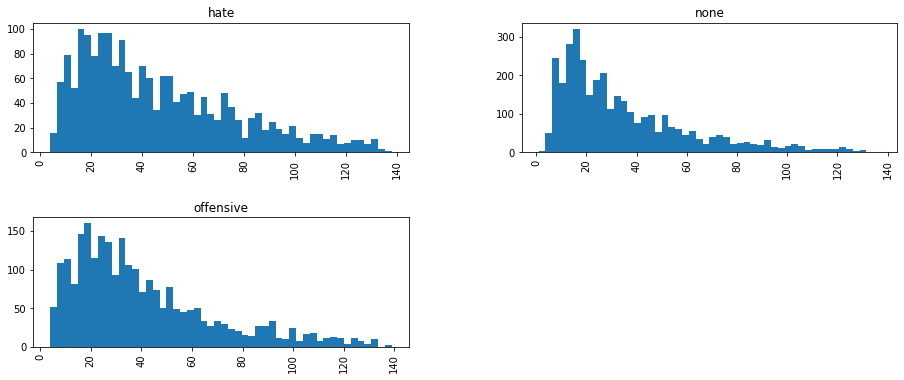

In [14]:
train['length'] = train['comments'].apply(len)
train.hist(column='length', by='hate_label', bins=50, figsize=(15,6));

In [21]:
stopwords = pd.read_csv('https://bab2min.tistory.com/attachment/cfile2.uf@241D6F475873C2B1010DEA.txt', sep='\t', header=None, names=['형태','품사','비율'])
stopwords_list = stopwords['형태'].tolist()

In [22]:
def process_text(text):
    clean_words = [word for word in text if word not in stopwords_list]
    return clean_words

train['comments'].apply(process_text).head()

0    [현, 재,  , 호, 텔,  , 인,  , 심, 정,  , 아, 1, 8,  , ...
1    [국, 인,  , 미, 인, 의,  , 대, 표, 인,  , 분,  , 너, 무, ...
2    [못, 된,  , 넘, 남, 의,  , 고, 통, 을,  , 즐, 겼, 던,  , ...
3    [1, 2, 화,  , 어, 설,  , 펐, 는,  , 3, 4,  , 화,  , ...
4    [1,  , 사, 람,  , 얼, 굴,  , 손, 톱, 으, 로,  , 긁, 은, ...
Name: comments, dtype: object

In [23]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, class_train, class_test = train_test_split(train['comments'], train['hate_label'], test_size=0.2)

In [24]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [25]:
text_clf.fit(msg_train, class_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [26]:
predictions = text_clf.predict(msg_test)
print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

        hate       0.73      0.13      0.22       385
        none       0.51      0.88      0.64       707
   offensive       0.37      0.22      0.27       488

    accuracy                           0.49      1580
   macro avg       0.53      0.41      0.38      1580
weighted avg       0.52      0.49      0.43      1580



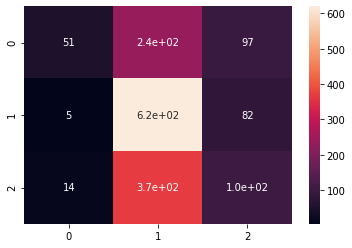

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(class_test, predictions), annot=True);

### trial with second version of train data
(remove punctuation marks, classify part of speech)

In [29]:
train_2 = pd.read_csv('./datas/train_ver2', index_col=[0])
train_2.tail()

,comments,bias_label,gender_label,hate_label,news_title,comment_pos,title_pos
7891,힘내세요 응원합니다,none,False,none,허지웅 허투루 넘길 말 없었다 솔직하게 드러냈던 속사정,"[('힘내세요', 'Verb'), ('응원', 'Noun'), ('합니다', 'Ve...","[('허지웅', 'Noun'), ('허투루', 'Noun'), ('넘길', 'Ver..."
7892,힘내세요삼가 고인의 명복을 빕니다,none,False,none,이혜경 오 캐롤 공연 중 남편 오정욱 부고 오열 속 발인 종합,"[('힘내세요', 'Verb'), ('삼가', 'Verb'), ('고인', 'Nou...","[('이혜경', 'Noun'), ('오', 'Noun'), ('캐롤', 'Noun'..."
7893,힘내세용 항상 응원합니닷,none,False,none,설경구 송윤아 아들과 즐거운 하루 전 엄마니까요,"[('힘내세용', 'Verb'), ('항상', 'Noun'), ('응원', 'Nou...","[('설경구', 'Noun'), ('송윤아', 'Noun'), ('아들', 'Nou..."
7894,힘내소연기로 답해요나도 53살 인데 이런일 저런일 다 있더라구요인격을 믿습니다홨팅,none,False,none,SC현장연예인 인생 협박 유감 미소잃은 최민수 보복운전 혐의 2차 공판종합,"[('힘내소', 'Verb'), ('연기', 'Noun'), ('로', 'Josa'...","[('SC', 'Alpha'), ('현장', 'Noun'), ('연예인', 'Nou..."
7895,힘들면 관뒀어야지 그게 현명한거다,none,False,none,단독스태프 사망사고 서른이지만 결국 오늘 촬영 취소,"[('힘들면', 'Adjective'), ('관', 'Noun'), ('뒀어야지',...","[('단독', 'Noun'), ('스태프', 'Noun'), ('사망', 'Noun..."


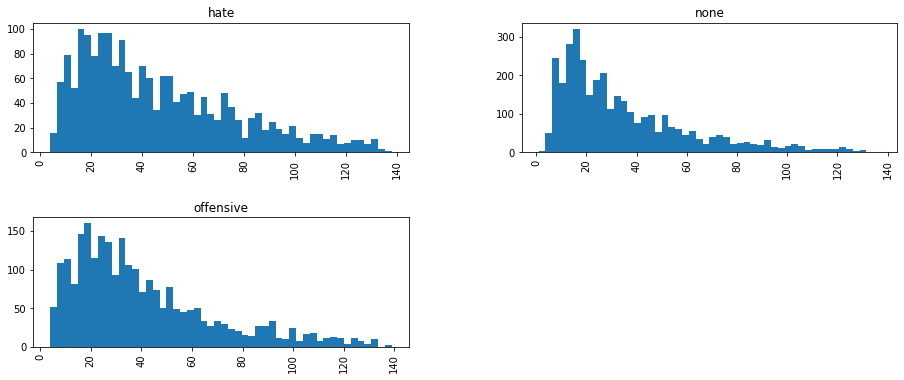

In [30]:
train_2['length'] = train['comments'].apply(len)
train_2.hist(column='length', by='hate_label', bins=50, figsize=(15,6));

In [31]:
train_2['comments'].apply(process_text).head()

0    [현, 재,  , 호, 텔, 인,  , 심, 정,  , 아, 1, 8,  , 난, ...
1    [국, 인,  , 미, 인, 의,  , 대, 표, 인,  , 분, 너, 무,  , ...
2    [못, 된,  , 넘, 남, 의,  , 고, 통, 을,  , 즐, 겼, 던,  , ...
3    [1, 2, 화,  , 어, 설, 펐, 는,  , 3, 4, 화,  , 서, 부, ...
4    [1,  , 사, 람,  , 얼, 굴,  , 손, 톱, 으, 로,  , 긁, 은, ...
Name: comments, dtype: object

In [33]:
msg_train, msg_test, class_train, class_test = train_test_split(train['comments'], train['hate_label'], test_size=0.2)
text_clf.fit(msg_train, class_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [34]:
predictions = text_clf.predict(msg_test)
print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

        hate       0.67      0.11      0.19       381
        none       0.51      0.91      0.66       698
   offensive       0.46      0.25      0.32       501

    accuracy                           0.51      1580
   macro avg       0.55      0.42      0.39      1580
weighted avg       0.53      0.51      0.44      1580



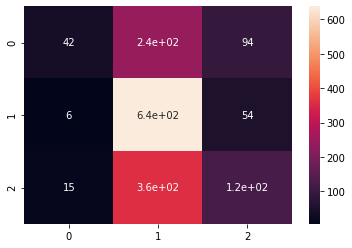

In [35]:
sns.heatmap(confusion_matrix(class_test, predictions), annot=True);